In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# LSTM
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Visualization
import plotly
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# mounting google drive for access to data sets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cite AQUACROP
filepath = '/content/drive/MyDrive/MathWorks #1 (BOS) - Smart Watering System with Internet of Things/Data/simulation_data.csv'
df = pd.read_csv(filepath, header=0)
df = df.rename(columns={
    'prepcipitation': 'precipitation'
})
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# inspect data set
print(f'The simulation data set has {df.shape[0]} rows and {df.shape[1]} columns.')
df.head(10)

The simulation data set has 4477 rows and 9 columns.


,time_step_counter,date_after_planting,avg_water_content,season_counter,min_temp,max_temp,precipitation,reference_et,date
0,0.00,1.00,0.22,1.00,-3.33,25.56,0.00,5.68,1982-04-01
1,1.00,2.00,0.22,1.00,-2.22,14.45,0.00,2.69,1982-04-02
2,2.00,3.00,0.21,1.00,-7.22,20.56,0.00,4.84,1982-04-03
3,3.00,4.00,0.21,1.00,-6.11,10.00,0.00,2.84,1982-04-04
4,4.00,5.00,0.21,1.00,-8.33,6.67,0.00,2.33,1982-04-05
5,5.00,6.00,0.21,1.00,-23.89,16.11,0.00,4.36,1982-04-06
6,6.00,7.00,0.21,1.00,-4.03,4.13,0.00,1.33,1982-04-07
7,7.00,8.00,0.21,1.00,-6.91,4.18,0.00,1.95,1982-04-08
8,8.00,9.00,0.21,1.00,-8.73,11.40,0.00,3.23,1982-04-09
9,9.00,10.00,0.21,1.00,-6.13,16.79,0.00,4.24,1982-04-10


**LSTM**

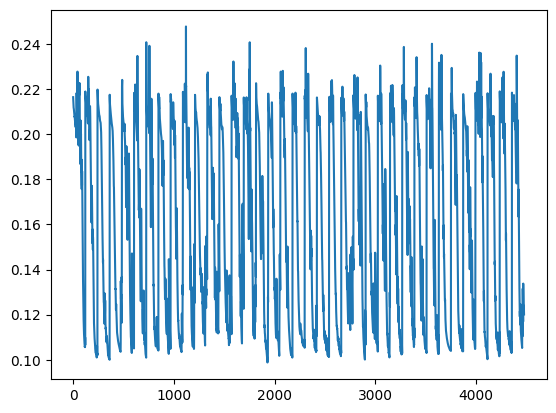

In [ ]:
plt.plot(df[['avg_water_content']])

In [ ]:
df = df[df['date'] >= '1982-01-01'].drop(['time_step_counter', 'season_counter', 'date'], axis=1)
# plt.plot(test_df['date'], test_df['avg_water_content'], color='green', linestyle='--', marker='o', linewidth=2, markersize=6)
# train = test_df[test_df['date'] <= '2018-01-01'].drop('date', axis=1)
# test = test_df[test_df['date'] > '2018-01-01'].drop('date', axis=1)
# test_df.head()

# features and target
# features = ['date_after_planting', 'min_temp', 'max_temp', 'precipitation', 'reference_et']
features = ['min_temp', 'max_temp', 'precipitation', 'reference_et']
target = 'avg_water_content'

# min-max scale features and targets for LSTM
scaler = MinMaxScaler()
#df_scaled = scaler.fit_transform(test_df[features + [target]])
df_scaled = scaler.fit_transform(df[features + [target]])

# split into input and target
X_scaled = df_scaled[:, :-1]
y_scaled = df_scaled[:, -1]

# reshape the target to be a 2D array
y_scaled = y_scaled.reshape(-1, 1)

In [ ]:
sequence_length = 8  # Number of previous days to consider for predicting the next day's soil moisture

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Convert the time series data into sequences
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=1)

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, X_train.shape[1]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
3573/3573 [==============================] - 32s 8ms/step - loss: 0.0352 - val_loss: 0.0208
Epoch 2/10
3573/3573 [==============================] - 27s 8ms/step - loss: 0.0225 - val_loss: 0.0209
Epoch 3/10
3573/3573 [==============================] - 27s 7ms/step - loss: 0.0197 - val_loss: 0.0235
Epoch 4/10
3573/3573 [==============================] - 27s 8ms/step - loss: 0.0188 - val_loss: 0.0167
Epoch 5/10
3573/3573 [==============================] - 27s 8ms/step - loss: 0.0182 - val_loss: 0.0306
Epoch 6/10
3573/3573 [==============================] - 26s 7ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 7/10
3573/3573 [==============================] - 28s 8ms/step - loss: 0.0171 - val_loss: 0.0193
Epoch 8/10
3573/3573 [==============================] - 29s 8ms/step - loss: 0.0163 - val_loss: 0.0214
Epoch 9/10
3573/3573 [==============================] - 26s 7ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 10/10
3573/3573 [==============================] - 27s 7ms/step - l

In [ ]:
# model evaluation on the test set
loss = model.evaluate(test_generator)
print(f'Test Loss: {loss}')

888/888 [==============================] - 3s 4ms/step - loss: 0.0166
Test Loss: 0.016649750992655754


In [ ]:
# make predictions
y_pred = model.predict(test_generator)
# Flatten y_pred and y_test if they are two-dimensional
y_pred = y_pred.flatten()
y_test_trimmed = y_test[sequence_length:].flatten()  # Aligning the true values
r_squared = r2_score(y_test_trimmed, y_pred)
print(f'R-squared: {r_squared}')

rmse = np.sqrt(mean_squared_error(y_test_trimmed, y_pred))
print(f'RMSE: {rmse}')
# Inverse the scaling to get actual soil moisture values
# predictions_actual = scaler.inverse_transform(np.concatenate((X_test[sequence_length:], predictions), axis=1))[:, -1]

888/888 [==============================] - 5s 4ms/step
R-squared: 0.8183840412539851
RMSE: 0.12903393683269856


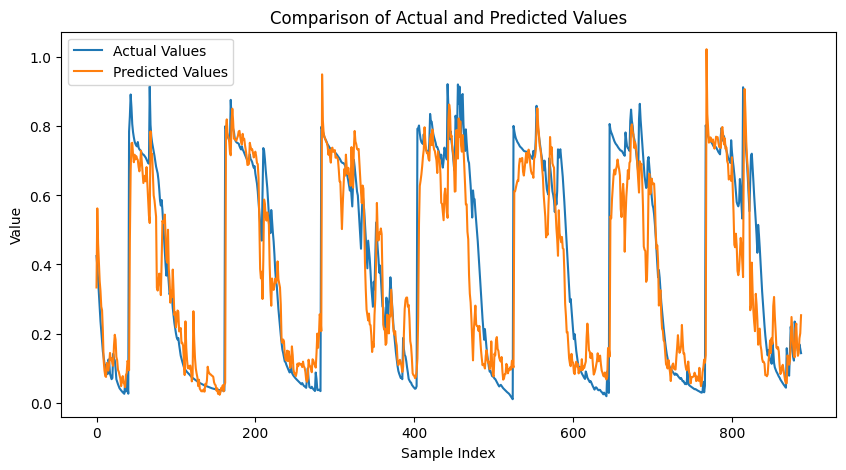

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_trimmed, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

**Training-Test Split**

In [ ]:
X = df.drop(columns = ['avg_water_content', 'date', 'time_step_counter', 'date_after_planting'], axis=1)
y = df['avg_water_content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

**Linear Regression Model**

In [ ]:
# Create the  LinearRegression model object
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

#  Make predictions on the test data
prediction = model.predict(X_test)

In [ ]:
# The mean squared error
print('\nModel Performance\n\nRMSE =   %.2f'
      % np.sqrt(mean_squared_error(y_test, prediction)))
# The coefficient of determination: 1 is perfect prediction
print(' R^2 =   %.2f'
      % r2_score(y_test, prediction))


Model Performance

RMSE =   0.02
 R^2 =   0.69


**Gradient-Boosting Decision Tree**

In [ ]:
# GBDT parameters for gridsearchCV
gbdt_param_grid = {'max_depth':[2,4,8,16], 'n_estimators':[50,100,200,300,500]}
gbdt_param_grid
print('Running Grid Search...')
# create GBDT model
gbdt_model = GradientBoostingRegressor(random_state=0)

# fit gridsearchCV
gbdt_grid = GridSearchCV(gbdt_model, gbdt_param_grid, cv=3, scoring='neg_root_mean_squared_error')
gbdt_grid_search = gbdt_grid.fit(X_train, y_train)

print('Done')

# get best GBDT parameter from gridsearchCV
best_params = gbdt_grid_search.best_params_
max_depth = best_params['max_depth']
n_estimators = best_params['n_estimators']
print("The best max_depth parameter is:", max_depth, "and the best n_estimators parameter is", n_estimators)

Running Grid Search...
Done
The best max_depth parameter is: 4 and the best n_estimators parameter is 100


In [ ]:
# create GBDT model with best parameters
gbdt_model = GradientBoostingRegressor(max_depth=4, n_estimators=100)
# train GBDT model
gbdt_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4)

In [ ]:
# make prediction of GBDT model on test set
gbdt_pred = gbdt_model.predict(X_test)

# evaluate GBDT performance using RMSE and r^2
gbdt_rmse = mean_squared_error(y_test, gbdt_pred, squared=False)
gbdt_r2 = r2_score(y_test, gbdt_pred)
print('\nGBDT Model Performance\n\nRMSE =   %.2f'% gbdt_rmse)
print('R^2 =   %.2f'% gbdt_r2)


GBDT Model Performance

RMSE =   0.02
R^2 =   0.76


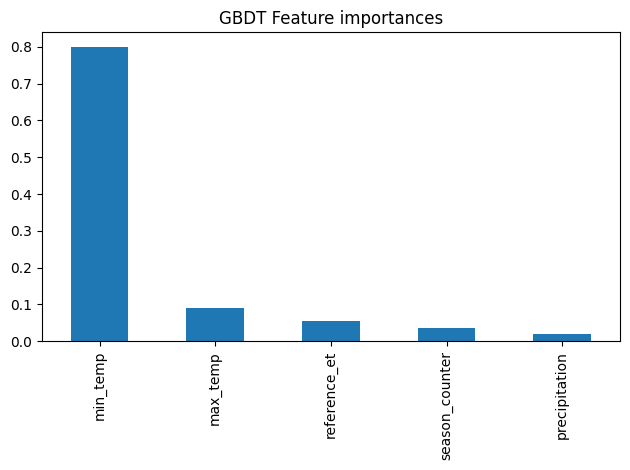

In [ ]:
# feature importances
gbdt_importances = pd.Series(gbdt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
# plot feature importances
fig, ax = plt.subplots()
gbdt_importances.plot.bar(ax=ax)
ax.set_title("GBDT Feature importances")
fig.tight_layout()